# Correr circuitos nos computadores da IBM
## [tinyurl.com/quantumuc-ibm](https://tinyurl.com/quantumuc-ibm)

O objetivo desta aula é correr o circuito que analisámos anteriormente nos computadores da IBM

Antes de começar, instalamos e importamos as bibliotecas necessárias

In [107]:
%%capture
%pip install qiskit qiskit-aer qiskit-ibm-runtime
%pip install matplotlib pylatexenc  # Para gerar gráficos

In [108]:
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

## Circuito para correr

In [109]:
from qiskit.circuit import Parameter
phi = Parameter('phi')  # Parâmetro phi
phi_values = np.linspace(0, 2*np.pi, 40)
phi_values

array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.1887902 , 4.34989752, 4.51100484, 4.67211215,
       4.83321947, 4.99432678, 5.1554341 , 5.31654141, 5.47764873,
       5.63875604, 5.79986336, 5.96097068, 6.12207799, 6.28318531])

E agora definimos o circuito em função deste parâmetro.

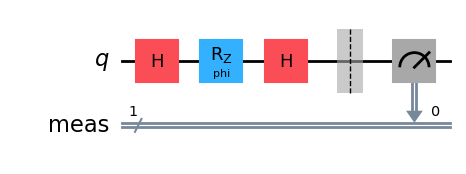

In [110]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(phi, 0)  # <-- Introduzimos aqui o parâmetro genérico.
qc.h(0)
qc.measure_all()

qc.draw('mpl')

## Simulação do circuito

No geral, correr circuitos num computador quântico pode ser simultaneamente dispendioso e demorado.

Assim, é importante testar o circuito sempre que possível, e só quando tivermos a certeza é que mandamos correr.

Para isso, vamos usar um _**backend**_ (computador) falso, que simula um computador real. Um _backend_ contém informação como o número de qubits, operações possíveis, topologia (i.e., que qubits podem falar entre si) e modelos de ruído, entre outras coisas.

In [111]:
from qiskit_ibm_runtime.fake_provider import FakeFez
backend_fake = FakeFez()

Em segundo lugar, vamos querer correr simulações com este _backend_.

Para isso precisamos de um _**Sampler**_ (simulador) baseado no computador que escolhemos.

In [112]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

E agora vem um passo importante.

Um computador quântico sabe fazer apenas um número muito limitado de operações.

No entanto, estas operações são suficientes para qualquer aplicação que queremos. Mas temos de ``traduzir'' o nosso circuito para essas mesmas operações.

A este passo chama-se _**transpilar**_ o circuito. A transpilação é feita por um ```Pass Manager```.

In [113]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

E finalmente conseguimos transpilar o nosso circuito.

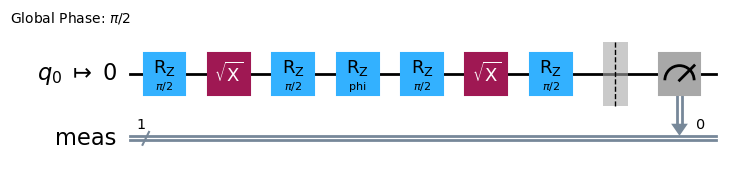

In [114]:
qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw('mpl')

Finalmente podemos correr a simulação do circuito, tal como na aula anterior.

Note-se: em vez de passarmos muitos circuitos, passamos apenas um circuito e os valores para os parâmetros.

O Qiskit encarrega-se de criar todos os circuitos por nós.

In [115]:
NSHOTS = 1024
job = sampler_fake.run([(qc_transpiled, phi_values)], shots=NSHOTS)
result = job.result()[0]

Agora extraimos os dados da simulação

In [116]:
xdata = phi_values
ydata = []

for experiment in result.data.meas:  # Cada circuito tem o seu resultado
  counts = experiment.get_counts()
  ydata.append(counts.get('0', 0.0) / NSHOTS)

E visualizamos os resultados das medições.

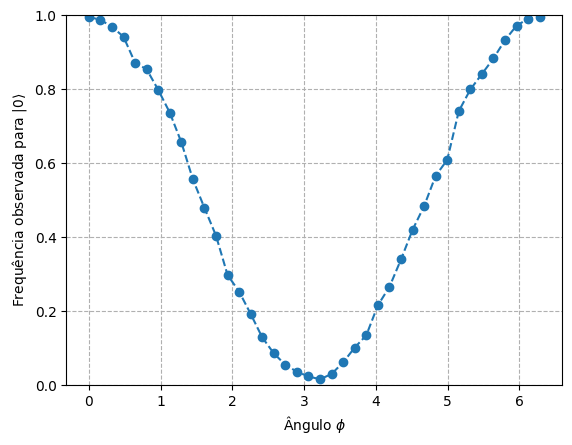

In [117]:
fig, ax = plt.subplots()

ax.plot(xdata, ydata, marker='o', linestyle='--')

ax.set_xlabel(r'Ângulo $\phi$')
ax.set_ylabel(r'Frequência observada para $|0\rangle$')
ax.set_ylim([0.0, 1.0])
ax.grid(linestyle='--')

## Correr num computador quântico real

Vamos agora correr o mesmo circuito num computador quântico real da IBM.

Para tal, precisamos de criar uma conta da IBM e importar os dados da conta (através de um _token_) para o notebook.

In [118]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [119]:
# Ligar à conta da IBM
import os
from qiskit_ibm_runtime import QiskitRuntimeService
# from google.colab import userdata

# TOKEN = userdata.get('TOKEN')
TOKEN = os.getenv('IBM_QISKIT_RUNTIME_TOKEN')
service = QiskitRuntimeService(channel="ibm_cloud", token=TOKEN)

qiskit_runtime_service._discover_account:WARNING:2025-11-25 19:30:17,084: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-25 19:30:23,552: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Quantum_UC. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Vamos então pedir à IBM para nos dar acesso ao seu computador menos ocupado no momento.

Também criamos já um simulador e um transpilador baseados neste backend.

In [120]:
# Importar um backend da IBM
backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(backend)
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1
)
print(backend)

qiskit_runtime_service.backends:WARNING:2025-11-25 19:30:24,824: Loading instance: Quantum_UC, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-25 19:30:28,260: Using instance: Quantum_UC, plan: open


<IBMBackend('ibm_fez')>


Transpilamos o circuito novamente, para este backend.

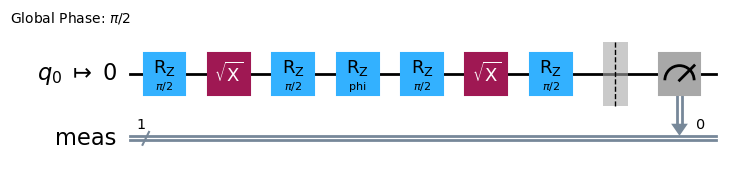

In [121]:
# Transpile circuit
isa_qc = pm.run(qc)
isa_qc.draw('mpl', idle_wires=False) # Just to show used qubits

Mas, desta vez, enviamos o circuito para os computadores da IBM.

In [122]:
# job = sampler.run([(isa_qc, phi_values)], shots=NSHOTS)
# job.job_id()

Assim que o ```job``` terminar, vamos pedir-lhe os resultados.

Check the usage at

https://quantum.cloud.ibm.com/workloads?user=me

In [123]:
job = service.job('d4ivqm43tdfc73dmup7g')
job_result = job.result()[0]

Extraimos os dados necessários, como antes.

In [124]:
# Plot data
xdata = phi_values
ydata = []

for experiment in job_result.data.meas:
  counts = experiment.get_counts()
  ydata.append(counts.get('0', 0.0) / NSHOTS)

E, finalmente, visualizamos os resultados.

(-0.05, 1.05)

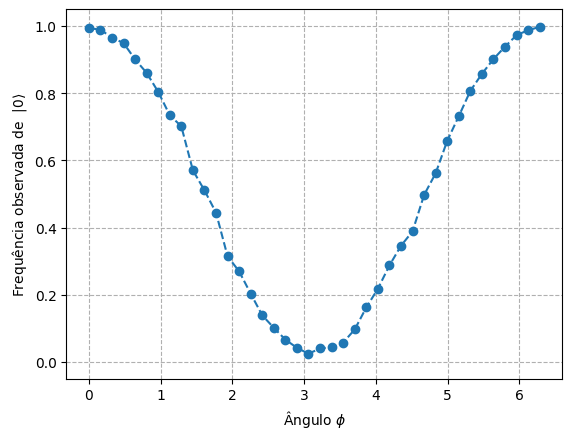

In [125]:
fig, ax = plt.subplots()

ax.plot(xdata, ydata, marker='o', linestyle='--')

ax.set_xlabel(r'Ângulo $\phi$')
ax.set_ylabel(r'Frequência observada de  $|0\rangle$')
ax.grid(linestyle='--')
ax.set_ylim([-0.05, 1.05])

# Exercise 2

In [126]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

## Gate X

In [127]:
qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [128]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

┌───┐ ░ ┌─┐
q_0 -> 0 ┤ X ├─░─┤M├
         └───┘ ░ └╥┘
 meas: 1/═════════╩═
                  0

## Gate Y

In [129]:
qc = QuantumCircuit(1)
qc.y(0)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ Y ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [130]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: π
         ┌───────┐┌───┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(π) ├┤ X ├─░─┤M├
         └───────┘└───┘ ░ └╥┘
 meas: 1/══════════════════╩═
                           0

## Gate Z

In [131]:
qc = QuantumCircuit(1)
qc.z(0)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ Z ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [132]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: π/2
         ┌───────┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(π) ├─░─┤M├
         └───────┘ ░ └╥┘
 meas: 1/═════════════╩═
                      0

## Gate H

In [133]:
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [134]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: π/4
         ┌─────────┐┌────┐┌─────────┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤M├
         └─────────┘└────┘└─────────┘ ░ └╥┘
 meas: 1/════════════════════════════════╩═
                                         0

## Gate Rx(pi/6)

In [135]:
qc = QuantumCircuit(1)
qc.rx(np.pi/6, 0)
qc.measure_all()
qc.draw()

┌─────────┐ ░ ┌─┐
     q: ┤ Rx(π/6) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0

In [136]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: 3π/2
         ┌─────────┐┌────┐┌──────────┐┌────┐┌──────────┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(7π/6) ├┤ √X ├┤ Rz(5π/2) ├─░─┤M├
         └─────────┘└────┘└──────────┘└────┘└──────────┘ ░ └╥┘
 meas: 1/═══════════════════════════════════════════════════╩═
                                                            0

## Gate Ry(pi/6)

In [137]:
qc = QuantumCircuit(1)
qc.ry(np.pi/6, 0)
qc.measure_all()
qc.draw()

┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/6) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0

In [138]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: 3π/2
         ┌────────┐┌────┐┌──────────┐┌────┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(-π) ├┤ √X ├┤ Rz(5π/6) ├┤ √X ├─░─┤M├
         └────────┘└────┘└──────────┘└────┘ ░ └╥┘
 meas: 1/══════════════════════════════════════╩═
                                               0

## Gate Rz(pi/6)

In [139]:
qc = QuantumCircuit(1)
qc.rz(np.pi/6, 0)
qc.measure_all()
qc.draw()

┌─────────┐ ░ ┌─┐
     q: ┤ Rz(π/6) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0

In [140]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

┌─────────┐ ░ ┌─┐
q_0 -> 0 ┤ Rz(π/6) ├─░─┤M├
         └─────────┘ ░ └╥┘
 meas: 1/═══════════════╩═
                        0

## Gate CNOT

In [141]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.measure_all()
qc.draw()

░ ┌─┐   
   q_0: ──■───░─┤M├───
        ┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1

In [142]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: π/2
                                                                     ░ ┌─┐   
q_0 -> 0 ─────────────────────────────■──────────────────────────────░─┤M├───
         ┌─────────┐┌────┐┌─────────┐ │ ┌─────────┐┌────┐┌─────────┐ ░ └╥┘┌─┐
q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫─┤M├
         └─────────┘└────┘└─────────┘   └─────────┘└────┘└─────────┘ ░  ║ └╥┘
 meas: 2/═══════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1

## Gate SWAP

In [143]:
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.measure_all()
qc.draw()

░ ┌─┐   
   q_0: ─X──░─┤M├───
         │  ░ └╥┘┌─┐
   q_1: ─X──░──╫─┤M├
            ░  ║ └╥┘
meas: 2/═══════╩══╩═
               0  1

In [144]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: 3π/2
         ┌────┐   ┌────┐   ┌────┐    ░ ┌─┐   
q_0 -> 0 ┤ √X ├─■─┤ √X ├─■─┤ √X ├─■──░─┤M├───
         ├────┤ │ ├────┤ │ ├────┤ │  ░ └╥┘┌─┐
q_1 -> 1 ┤ √X ├─■─┤ √X ├─■─┤ √X ├─■──░──╫─┤M├
         └────┘   └────┘   └────┘    ░  ║ └╥┘
 meas: 2/═══════════════════════════════╩══╩═
                                        0  1

## Gate CCNOT

In [145]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.measure_all()
qc.draw()

░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2

In [146]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: 7π/8
                                                                             »
 q_1 -> 96 ─■────────────────────────────────────────────────────────────────»
            │                                                                »
q_0 -> 102 ─┼───────────────────────────────────────────────────■────────────»
            │ ┌──────────┐┌────┐┌───────────┐┌────┐┌──────────┐ │ ┌─────────┐»
q_2 -> 103 ─■─┤ Rz(-π/2) ├┤ √X ├┤ Rz(-3π/4) ├┤ √X ├┤ Rz(-π/2) ├─■─┤ Rz(π/2) ├»
              └──────────┘└────┘└───────────┘└────┘└──────────┘   └─────────┘»
   meas: 3/══════════════════════════════════════════════════════════════════»
                                                                             »
«                                                  ┌──────────┐┌────┐»
« q_1 -> 96 ─────────────────────────────────────■─┤ Rz(3π/4) ├┤ √X ├»
«                                                │ └──────────┘└────┘»
«q_0 -> 102 ─────────────────────────────────────┼───────────────────»
«           ┌────┐┌───────────┐┌────┐┌─────────┐ │ ┌──────────┐┌────┐»
«q_2 -> 103 ┤ √X ├┤ Rz(-3π/4) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(-π/2) ├┤ √X ├»
«           └────┘└───────────┘└────┘└─────────┘   └──────────┘└────┘»
«   meas: 3/═════════════════════════════════════════════════════════»
«                                                                    »
«            ┌─────────┐                                                   »
« q_1 -> 96 ─┤ Rz(π/2) ├───────────────────────────────────────────────────»
«            └─────────┘                         ┌────┐                    »
«q_0 -> 102 ────────────────────────────────■────┤ √X ├────────────────────»
«           ┌───────────┐┌────┐┌──────────┐ │ ┌──┴────┴─┐┌────┐┌──────────┐»
«q_2 -> 103 ┤ Rz(-3π/4) ├┤ √X ├┤ Rz(-π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/4) ├»
«           └───────────┘└────┘└──────────┘   └─────────┘└────┘└──────────┘»
«   meas: 3/═══════════════════════════════════════════════════════════════»
«                                                                          »
«                                                    ┌──────────┐┌────┐»
« q_1 -> 96 ───────────────────────────────────────■─┤ Rz(-π/2) ├┤ √X ├»
«                               ┌────┐   ┌────┐    │ └──────────┘└────┘»
«q_0 -> 102 ──────────────────■─┤ √X ├─■─┤ √X ├─■──┼───────────────────»
«           ┌────┐┌─────────┐ │ ├────┤ │ ├────┤ │  │ ┌─────────┐       »
«q_2 -> 103 ┤ √X ├┤ Rz(π/2) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ Rz(π/4) ├───────»
«           └────┘└─────────┘   └────┘   └────┘      └─────────┘       »
«   meas: 3/═══════════════════════════════════════════════════════════»
«                                                                      »
«           ┌───────────┐┌────┐┌──────────┐   ┌─────────┐┌────┐┌─────────┐ ░ »
« q_1 -> 96 ┤ Rz(-3π/4) ├┤ √X ├┤ Rz(-π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─»
«           └───────────┘└────┘└──────────┘ │ └─────────┘└────┘└─────────┘ ░ »
«q_0 -> 102 ────────────────────────────────┼──────────────────────────────░─»
«                                           │                              ░ »
«q_2 -> 103 ────────────────────────────────■──────────────────────────────░─»
«                                                                          ░ »
«   meas: 3/═════════════════════════════════════════════════════════════════»
«                                                                            »
«              ┌─┐   
« q_1 -> 96 ───┤M├───
«              └╥┘┌─┐
«q_0 -> 102 ────╫─┤M├
«           ┌─┐ ║ └╥┘
«q_2 -> 103 ┤M├─╫──╫─
«           └╥┘ ║  ║ 
«   meas: 3/═╩══╩══╩═
«            0  1  2

# Exercise 3

In [147]:
qc = QuantumCircuit(3)
qc.h(0)
qc.barrier()
qc.cx(0, 1)
qc.cx(0, 2)

qc.measure_all()
qc.draw()

┌───┐ ░            ░ ┌─┐      
   q_0: ┤ H ├─░───■────■───░─┤M├──────
        └───┘ ░ ┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ──────░─┤ X ├──┼───░──╫─┤M├───
              ░ └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────░──────┤ X ├─░──╫──╫─┤M├
              ░      └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════╩══╩══╩═
                              0  1  2

In [148]:
backend_fake = FakeFez()

sampler_fake = Sampler(backend_fake)  # Aqui passamos o backend para o simulador

pm_fake = generate_preset_pass_manager(
    backend=backend_fake,
    optimization_level=1
)

qc_transpiled = pm_fake.run(qc)
qc_transpiled.draw()

global phase: 5π/4
                                        ░ ┌─────────┐┌────┐┌─────────┐   »
q_1 -> 136 ─────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─»
                                        ░ ├─────────┤├────┤├─────────┤ │ »
q_2 -> 142 ─────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┼─»
           ┌─────────┐┌────┐┌─────────┐ ░ └─────────┘└────┘└─────────┘ │ »
q_0 -> 143 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──────────────────────────────■─»
           └─────────┘└────┘└─────────┘ ░                                »
   meas: 3/══════════════════════════════════════════════════════════════»
                                                                         »
«           ┌─────────┐   ┌────┐  ┌─────────┐            ░    ┌─┐   
«q_1 -> 136 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├────────────░────┤M├───
«           └─────────┘┌──┴────┴─┐└──┬────┬─┘┌─────────┐ ░    └╥┘┌─┐
«q_2 -> 142 ─────■─────┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├─░─────╫─┤M├
«                │     └─────────┘   └────┘  └─────────┘ ░ ┌─┐ ║ └╥┘
«q_0 -> 143 ─────■───────────────────────────────────────░─┤M├─╫──╫─
«                                                        ░ └╥┘ ║  ║ 
«   meas: 3/════════════════════════════════════════════════╩══╩══╩═
«                                                           0  1  2

In [149]:
NSHOTS = 1024
job = sampler_fake.run([(qc_transpiled, )], shots=NSHOTS)
result = job.result()[0]

In [150]:
result.data.meas.get_counts()

{'111': 502,
 '000': 495,
 '101': 6,
 '011': 7,
 '110': 8,
 '010': 1,
 '001': 2,
 '100': 3}

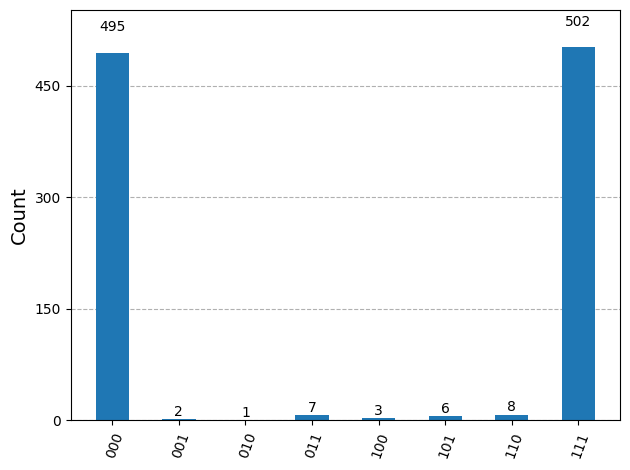

In [151]:
# Plot histogram
from qiskit.visualization import plot_histogram
plot_histogram(result.data.meas.get_counts())